# AGN light curve Pipeline
This code is a pipeline to generate simulated AGN light curve based on Kelly 2009.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker181
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from scipy.integrate import quad, dblquad
from tqdm import tqdm
import psi 
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous
from scipy.signal import convolve
import csv


# Constants, try to keep them in SI units
G = 6.674e-11  # Universal gravitational constant (m^3 kg^-1 s^-2)
c     = 2.9979e8 # Speed of light
M_sol   = 1.989e30 # Solar mass in kg
ld    = 2.59e13 # Light day in m
sigma = 5.67e-8 # Stefan-Boltzmann constant
h    = 6.626e-34 # Planck constant
k   = 1.38e-23 # Boltzmann constant

## Observational Wavelengths

In [2]:
wavref = [3650,4640,6580,8060,9000,10200]
deredshift_wav05 = [2433, 3093, 4387, 5373, 6000, 6800]
deredshift_wav1 = [1825, 2320, 3290, 4030, 4500, 5100]
deredshift_wav2 = [1216, 1546, 2193, 2686, 3000, 3400]

## Damped Random Walk
Here are a set of functions used to generate the DRW light curve. The generate_DRW function requires the relaxation time and the standard deviation of the light curve at short time scale. The calculation for these two values requires the mass of the SMBH and luminosity of the AGN. The luminosity is calulated as a fraction of the Eddington luminosity.


In [3]:
def relaxation_time(M, L, lam = 1):
    """
    Calculate the relaxation time of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in kg
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    M=M/M_sol
    tau_relax = 80.4*((lam*L/(10**45))**(-0.42)) * ((M/10**8)**1.03)
    
    ### Need correcting
    tau_relax_error = tau_relax - (80.4+66.9)*(lam*L/(10**45))**(-0.42+0.28) * (M/10**8)**(1.03+0.38)
    return tau_relax, tau_relax_error    

def drw_sigma(M, L, lam = 1):
    """
    Calculate the long-term variation amplitude of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in Kg
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    M=M/M_sol
    log_sigma2 = -3.83-0.09*np.log(lam*L/10**45) * -0.25*np.log(M/10**8)
    sigma = np.sqrt(10**log_sigma2)

    ### Need correcting
    sigma_error = sigma - (0.18+0.11)*(lam*L/(10**45))**(0.18-0.09) * (M/10**8)**(0.18+0.09)
    return sigma, sigma_error

def eddington_acc(M, effi = 0.1):
    """
    Calculate the Eddington accretion rate of an AGN.
    Parameters
    ----------
    M (float): Black hole mass in kg
    effi (float): Eddington efficiency; default=0.1
    """
    M_p = 1.6726219e-27 # Proton mass in kg
    t_cross_sec = 6.6524587e-29 # Thomson cross section in m^2
    M_dot = 4*np.pi*G*M*M_p/(effi*c*t_cross_sec) # Eddington accretion rate in kg/s
    return M_dot

def absolute_magnitude(luminosity, L_sun=3.828e26 * 10**7, M_sun=4.83):
    """
    Calculate the absolute magnitude of an astronomical object given its luminosity.
    
    Parameters:
    - luminosity (float): The luminosity of the object in watts.
    - L_sun (float, optional): The luminosity of the Sun in watts. Default is 3.828e26 * 10**7 erg/s.
    - M_sun (float, optional): The absolute magnitude of the Sun. Default is 4.83.
    
    Returns:
    - float: The absolute magnitude of the object.
    """
    return M_sun - 2.5 * np.log10(luminosity / L_sun)

def fvf_cal(sfinf,avg_flux):
    '''
    Calculate the fractional variability amplitude from the structure function
    Parameters
    ----------
    sfinf : float
        Structure function at infinity
    avg_flux : float
        Average flux
    Returns
    -------
    float
        Fractional variability amplitude
    '''
    fvf = np.sqrt(sfinf/2)/avg_flux
    return fvf

def flux_to_magnitude(flux_mJy, F0=3631):
    """
    Convert flux in millijanskys (mJy) to astronomical magnitude.
    Parameters
    ----------
    flux_mJy : float
        The flux of the object in mJy.
    F0 : float, optional
        The reference flux in mJy (default: 3631 mJy for AB magnitudes).
    Returns
    ------- 
    float
        The astronomical magnitude.
    """
    
    return -2.5 * np.log10(flux_mJy / F0)


def mac10_sf(M_BH, M_i, lambda_RF):
    """
    Computes the log structure function SF_infinity using Equation 7 from MacLeod et al. (2012).
    
    Parameters:
    M_BH (float): Black hole mass in solar masses.
    M_i (float): Absolute i-band magnitude.
    lambda_RF (float): Rest-frame wavelength in Angstroms.
    
    Returns:
    float:  SF_infinity.
    """
    # Constants from MacLeod et al. (2012)
    A = -0.51
    B = -0.479
    C = 0.131
    D = 0.18

    # Compute log SF_infinity
    log_SF_inf = (A + 
                  B * np.log10(lambda_RF / 4000) + 
                  C * (M_i + 23) + 
                  D * np.log10(M_BH / 1e9))
    
    return 10**log_SF_inf

def mac10_tau(M_BH, M_i, lambda_RF):
    """
    Computes the log tau using Equation 7 from MacLeod et al. (2012).
    
    Parameters:
    M_BH (float): Black hole mass in solar masses.
    M_i (float): Absolute i-band magnitude.
    lambda_RF (float): Rest-frame wavelength in Angstroms.
    
    Returns:
    float: tau [days]
    """
    # Constants from MacLeod et al. (2012)
    A = 2.4
    B = 0.17
    C = 0.03
    D = 0.21

    # Compute log SF_infinity
    log_tau = (A + 
                  B * np.log10(lambda_RF / 4000) + 
                  C * (M_i + 23) + 
                  D * np.log10(M_BH / 1e9))
    
    return 10**log_tau

# Constants from the paper for different time scales
BEST_FIT_PARAMS = {
    "M": {  # log(variance) = a * log(M/M_8.5) + b
        300: {"a": -0.13, "b": -2.85},  # 300d time-scale
        150: {"a": -0.35, "b": -3.06},  # 150d time-scale
        75: {"a": -0.66, "b": -3.24},   # 75d time-scale
        30: {"a": -1.03, "b": -3.66},   # 30d time-scale
    },
    "R_Edd": {  # log(variance) = a * log(R_Edd/0.1) + b
        300: {"a": -0.53, "b": -2.89},
        150: {"a": -0.62, "b": -3.08},
        75: {"a": -0.74, "b": -3.25},
        30: {"a": -0.95, "b": -3.64},
    },
    "L_bol": {  # log(variance) = a * (log(L_bol) - 45.8) + b
        300: {"a": -0.33, "b": -3.01},
        150: {"a": -0.53, "b": -3.25},
        75: {"a": -0.76, "b": -3.48},
        30: {"a": -1.01, "b": -3.95},
    },
}

# Reference values
REF_VALUES = {
    "M": 10**8.5,  # Reference mass in solar masses
    "R_Edd": 0.1,  # Reference Eddington ratio
    "L_bol": 10**45.8,  # Reference luminosity in erg/s
}


def compute_variance(X, X_type, time_scale):
    """
    Compute the variance using the best-fit linear model.

    Parameters:
    X (float): The independent variable (M, R_Edd, or L_bol).
    X_type (str): The type of variable ("M", "R_Edd", or "L_bol").
    time_scale (int): The time scale in days (30, 75, 150, or 300).

    Returns:
    float: The computed variance.
    """
    if X_type not in BEST_FIT_PARAMS:
        raise ValueError(f"Invalid X_type. Choose from {list(BEST_FIT_PARAMS.keys())}")
    if time_scale not in BEST_FIT_PARAMS[X_type]:
        raise ValueError(f"Invalid time scale. Choose from {list(BEST_FIT_PARAMS[X_type].keys())}")

    a = BEST_FIT_PARAMS[X_type][time_scale]["a"]
    b = BEST_FIT_PARAMS[X_type][time_scale]["b"]
    X0 = REF_VALUES[X_type]

    log_variance = a * (np.log10(X) - np.log10(X0)) + b
    return 10**log_variance  # Convert log(variance) back to variance



def generate_DRW(t_rest,mean_flux=0 ,tau=200,z=0,b=0,sigma=0.03,seed=0):
    """
    Simulates an AGN light curve using the Damped Random Walk (DRW) model (Kelly 2009).

    Parameters
    ----------
    t_rest (array_like): rest-frame time (sorted).  
    mean_flux (float): mean flux; default=10
    tau (float): relaxation time
    z (float): redshift
    mean_vari (float): mean light curve variation; default=0
    b (float): mean variation amplitude; default=0
    sigma (float): long-term variation amplitude; default=1
    seed (int): random seed for np.random

    Returns
    -------
    x (ndarray): Flux values at each time in t_rest
    """
    np.random.seed(seed)
    mean_vari = b * tau
    variance = sigma * np.sqrt(tau / 2)

    N = len(t_rest)

    t_obs = t_rest * (1 + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(mean_vari, variance)
    epsilon = np.random.normal(0, 1, N) # White noise
    #dX(t) = -X(t) * dt + sigma * sqrt(tau) * e(t) * sqrt(dt) + b * tau * dt
    #Xmean = b * tau
    #SFinf = sigma * sqrt(tau / 2)
    
    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1] - dt * (x[i - 1] - mean_vari) 
                + sigma * np.sqrt(tau) * epsilon[i] * np.sqrt(dt)
                +b * tau * dt)

    x = x + mean_flux
    t_obs = t_rest * (1 + z)
    return x,t_obs

### Fiducial AGN
We will use a fiducial AGN with mass of 1e8.5 solar mass and 10% Eddington Lumonosity at z=0.5, 1, and, 2.

In [4]:
# Time points 
days = np.arange(0.0,10 * 365,1) # 1 day sampling for 10 years

M = 10**8.5 * M_sol # Black hole mass in kg
M_dot = 1*M_sol/(365*24*3600) # kg per second
M_dot_edd = eddington_acc(M)*0.1
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s
abs_mag = absolute_magnitude(L)

DRW_sigma = drw_sigma(10**8,L)[0]
tau_relax = relaxation_time(M,L)[0]

print('1 M_sol per year [Kg/s]:',f'{M_dot:.3e}'
      ,'\n10% Eddington Accretion [kg/s]: ' , f'{eddington_acc(M)*0.1:.3e}')
print('Luminosity [erg/s]: ',f'{L:.3e}')

print('\nKelly 2009 DRW parameters:')
print('Relaxation Time [days]: ',round(tau_relax,4))
print('Sigma: ',round(DRW_sigma,4))
print('SFinf', DRW_sigma * np.sqrt(tau_relax / 2))

print('\nMacLeod 2010 DRW parameters:')
print('Relaxation Time [days]: ',round(mac10_tau(M/M_sol,abs_mag,4000),4))
print('SFinf: ',round(mac10_sf(M/M_sol,abs_mag,4000),4))

print('\nArevalo 2023 Variance')
print('Variance 30 days: ',round(compute_variance(M/M_sol, "M", 300),4))
print('SFinf: ',(2*compute_variance(M/M_sol, "M", 300)**2))


1 M_sol per year [Kg/s]: 6.307e+22 
10% Eddington Accretion [kg/s]:  4.424e+22
Luminosity [erg/s]:  3.976e+45

Kelly 2009 DRW parameters:
Relaxation Time [days]:  147.3945
Sigma:  0.001
SFinf 0.008617340127081579

MacLeod 2010 DRW parameters:
Relaxation Time [days]:  169.3024
SFinf:  0.1289

Arevalo 2023 Variance
Variance 30 days:  0.0014
SFinf:  3.990524629937757e-06


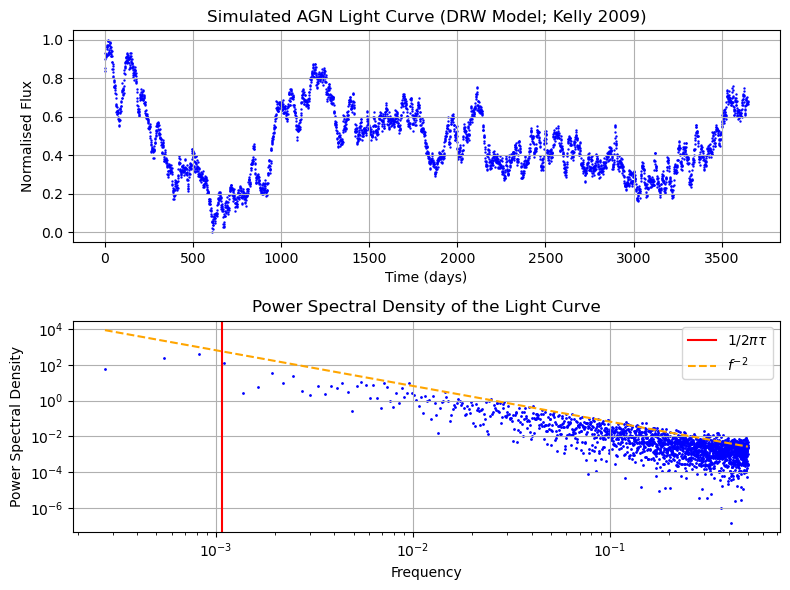

In [5]:
light_curve, t_obs = generate_DRW(days,tau = tau_relax,sigma=DRW_sigma, z=0.0, seed=0)

def normalise(light_curve_data):
    return (light_curve_data - np.min(light_curve_data)) / (np.max(light_curve_data) - np.min(light_curve_data))

normalised_lc = normalise(light_curve)
# Compute the power spectral density
f, PSD = PSD_continuous(days, light_curve)
alpha = PSD[-1] / f[-1]**-2

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the simulated light curve
axs[0].scatter(days, normalised_lc, s=0.5, color='blue')
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Normalised Flux')
axs[0].set_title('Simulated AGN Light Curve (DRW Model; Kelly 2009)')
axs[0].grid(True)

# Plot the power spectral density
axs[1].scatter(f, PSD, s=1, color='blue')
axs[1].axvline(1/(2*np.pi*tau_relax), color='red', label=r'1/2$\pi\tau$')
# Plot a line proportional to frequency^-2 for comparison
axs[1].loglog(f[1:], alpha*(f[1:]**-2), label=r'$f^{-2}$', linestyle='--', color='orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power Spectral Density')
axs[1].set_title('Power Spectral Density of the Light Curve')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Temperature Profile & Disc Continuum Emission
In order to calculate the measured flux, we need to know the continuum emission from the disc. We assume the disc to be geometrically thin and optically thick. The continuum spectrum is given by the sum of the blackbody spectrum at each radius of the disc.

In [6]:
def temp_r(radius, M, M_dot, hx, albedo, efficiency, r_in):
    """
    Calculate the temperature of an accretion disk at a given radius.

    Parameters
    ----------
    radius (float): radius in light days
    M (float): mass of the black hole in solar masses
    M_dot (float): accretion rate in solar masses per year
    hx (float): height of the disk at the radius in gravitational radii
    albedo (float): albedo of the disk
    efficiency (float): efficiency parameter
    """
    M_sol   = 1.989e30  # Solar mass in kg
    ld    = 2.59e13 # Light day in m

    rs    = 2*G*M/c**2 # Schwarzschild radius in m
    r_in = r_in*rs # Inner radius of the disk in m
    hx    = hx*rs # Height of lamp in m
    Lb    = efficiency*M_dot*c**2 # Luminosity of the disk in W

    temp_vis = (3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius)))**(1/4)
    temp_irr = ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt((radius**2)+(hx**2)))**3))**(1/4)
    temp_tot = ((3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius))) 
             + ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt(((radius)**2)+(hx**2)))**3)) )**(1/4)
    return temp_tot, temp_vis, temp_irr


def weins_law(T): #angstrom
    return  0.0029* 1e10/T 

def grav_radius(M): # Mass in Kg
    return 2*G*M/c**2

### Starkey 2016 Fig 1, R_in = Rs
Here we reproduced Starkey 2016 plot for 1e8 M_sol and 1M_dot AGN with R_in = Rs.

Gravitational Radius [m]:  295404221161.55774


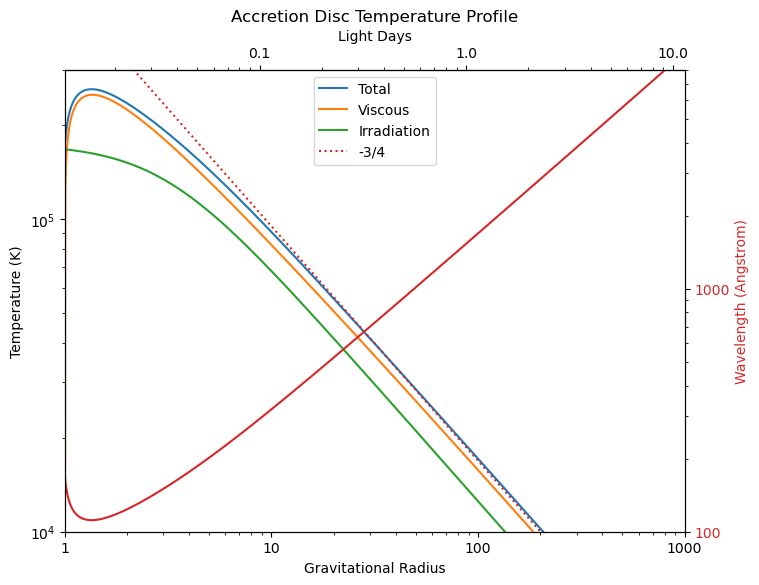

In [7]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = grav_radius(M) # Schwarzschild radius in m
r_in = 1 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

print('Gravitational Radius [m]: ',rs)
radii = np.logspace(np.log10(rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

emitting_lambda = weins_law(temp_prof)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.plot(radii/rs, (3e0*(radii[999]/rs)/(radii[999]/rs)**(-3/4))*(radii/rs)**(-3/4)
         , label='-3/4', linestyle=':')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(1, 1000)
axs.legend(loc='upper center')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.set_ylim(100,8000)
#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

### Fiducial AGN with R_in = 3 Rs

Temperature at R0 [k]:  21913.960554005356
Gravitational Radius [m]:  934150169298.6335
Light Days [m]:  25900000000000.0
27.725734952706695
52887 58560 66769 71510 74085


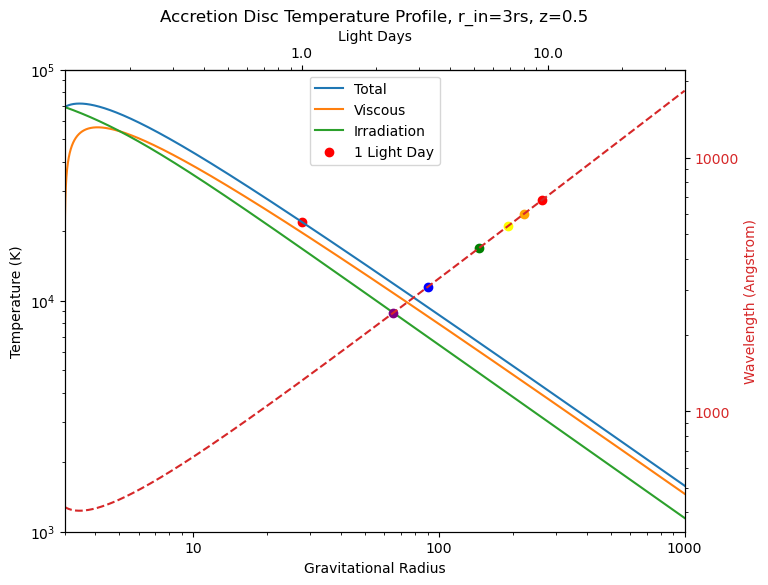

In [8]:
# Time points 
days = np.arange(0.0,10 * 365,1) # 1 day sampling for 10 years

M = 10**8.5 * M_sol # Black hole mass in kg
M_dot_edd = eddington_acc(M)*0.1 # kg per second
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s

DRW_sigma = drw_sigma(10**8,L)[0]
tau_relax = relaxation_time(M,L)[0]

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 100000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot_edd),hx,albedo,efficiency,r_in)

# Temperature at R0
temp_r0_index = np.where(radii >= ld)[0]
temp_r0 = temp_prof[temp_r0_index[0]]
print('Temperature at R0 [k]: ',temp_r0)
print('Gravitational Radius [m]: ',rs)
print('Light Days [m]: ',ld)
print(ld/rs)
emitting_lambda = weins_law(temp_prof)


# Rest Frame Wavelength
wav_index1 = np.where(emitting_lambda >= deredshift_wav05[0])[0]
wav_index2 = np.where(emitting_lambda >= deredshift_wav05[1])[0]
wav_index3 = np.where(emitting_lambda >= deredshift_wav05[2])[0]
wav_index4 = np.where(emitting_lambda >= deredshift_wav05[3])[0]
wav_index5 = np.where(emitting_lambda >= deredshift_wav05[4])[0]
wav_index6 = np.where(emitting_lambda >= deredshift_wav05[5])[0]
print(wav_index1[0],wav_index2[0],wav_index3[0],wav_index4[0],wav_index5[0])   



# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs, z=0.5')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e3, 1e5)
axs.set_xlim(r_in, 1000)
axs.legend(loc='upper center')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color, linestyle='--') 
ax2.scatter(radii[wav_index1[0]]/rs, emitting_lambda[wav_index1[0]],color = 'purple')
ax2.scatter(radii[wav_index2[0]]/rs, emitting_lambda[wav_index2[0]],color = 'blue')
ax2.scatter(radii[wav_index3[0]]/rs, emitting_lambda[wav_index3[0]],color = 'green')
ax2.scatter(radii[wav_index4[0]]/rs, emitting_lambda[wav_index4[0]],color = 'yellow')
ax2.scatter(radii[wav_index5[0]]/rs, emitting_lambda[wav_index5[0]],color = 'orange')
ax2.scatter(radii[wav_index6[0]]/rs, emitting_lambda[wav_index6[0]],color = 'red')
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.set_ylim(100,8000)

#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())


### Continuum Spectrum

In [9]:
inclination = 0
# Mpc at z=.05
mpc = 1908.7 
def Mpc2Cm(d):
    return d*3.086e24
distance = Mpc2Cm(mpc) # Mpc to cm
erg = 1e7 # J to erg

# Define the Planck function, F_nu
def planck_function(freq, temp):
    # Computes black body intensity (J/m^2/s/Hz/sr) at given temperature and frequency.

    c1 = (2 * k**3)/(c**2 * h**2) # (2kb^3)/(c^2h^2)
    c2 = h / k # h/kb
    
    x = c2 * freq / temp

    if (x < 1e-5): # Rayleigh-Jeans tail
        Planck = c1*(x**2)*(temp**3)
    else:
        Planck = c1*(x**3)*(temp**3) / (np.expm1(x))
    return Planck

# Define the integrand for the emitted spectrum
def integrand(r, lam):
    temp_prof, _, _ = temp_r(r, M, M_dot, hx, albedo, efficiency, r_in)
    if np.isnan(temp_prof):
        return 0
    freq = c / lam
    return planck_function(freq, temp_prof) * 2 * np.pi * r * np.cos(inclination) / distance**2

# Define the wavelength range (in meters)
#wavelengths = np.linspace((1e-8), (1e-3), 10000)  # Wavelength in meters
wavelengths = np.logspace(np.log10(1e-8), np.log10(1e-3), 10000)  # Wavelength in meters
# Define the radius range (in rs)
r_min = rs*3 #m
r_max = (rs*1000) #m
print(r_min/ld, r_max/ld)

# Compute the emitted spectrum by integrating over the radius range
emitted_spectrum = []
for lam in wavelengths:
    spectrum, _ = quad(integrand, r_min, r_max, args=(lam,),limit=50)
    #spectrum = spectrum*()
    emitted_spectrum.append(spectrum)

# Convert the emitted spectrum to a numpy array
emitted_spectrum = np.array(emitted_spectrum)

0.10820272231258303 36.06757410419434


C:\Users\nikko\AppData\Local\Temp\ipykernel_25976\1592645019.py:21: RuntimeWarning: overflow encountered in expm1
  Planck = c1*(x**3)*(temp**3) / (np.expm1(x))


Here we plot the continuum spectrum in the rest frame with the centre of each bandpass marked on the spectrum.

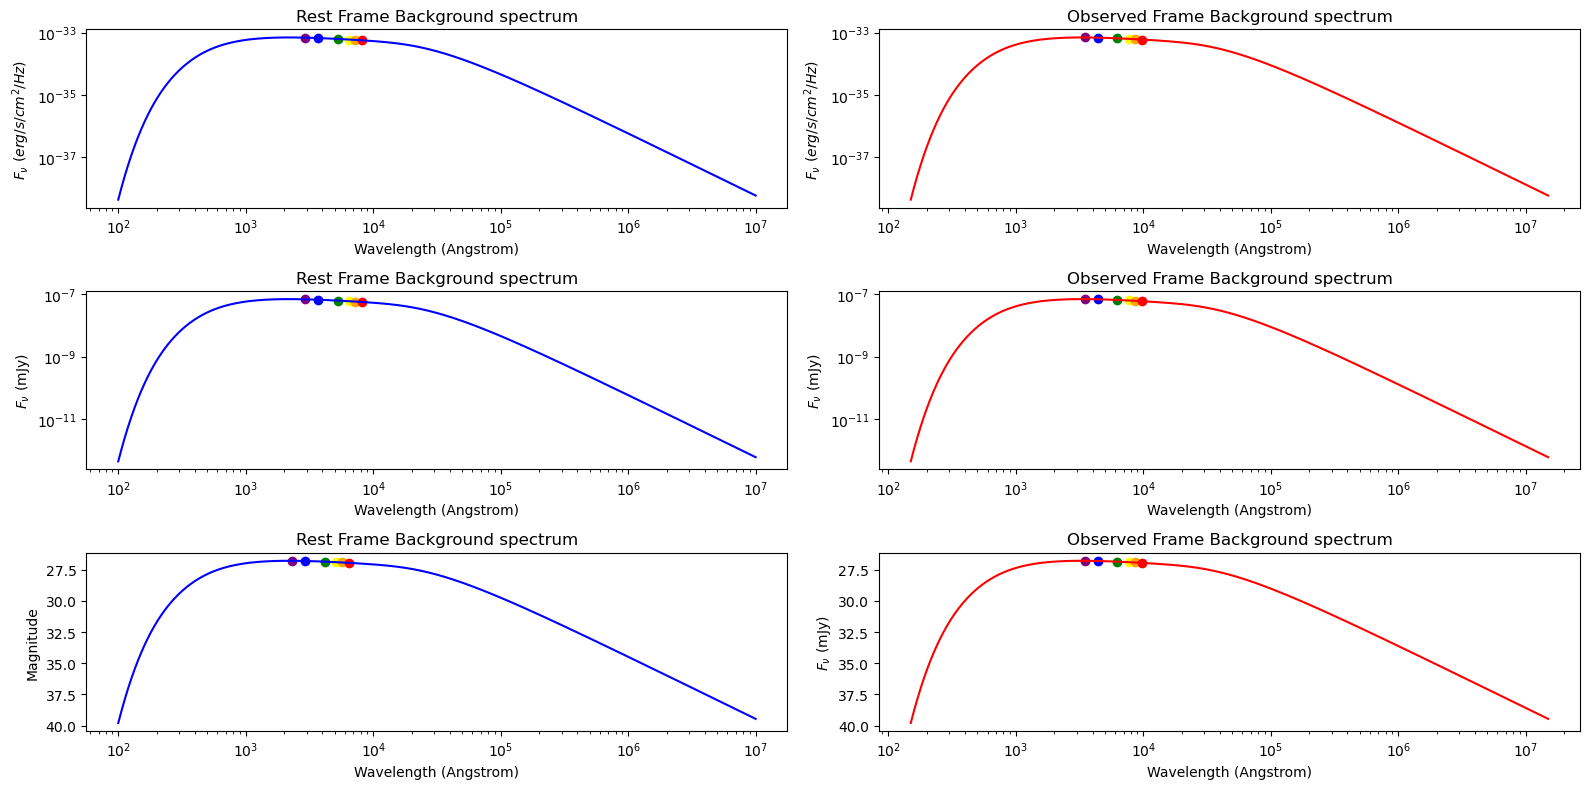

In [10]:
background_L = []
background_index = []
for wav in wavref:
    index = np.where((wavelengths >= 0.8*(wav*1e-10)) & (wavelengths <= 1.1*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    background_index.append(index[0])
    #print(wav, emitted_spectrum[index][0])
# Create subplots
rayleigh_jean_tail = 6000
weins_tail = 200
fig, axs = plt.subplots(3, 2, figsize=(16, 8))
axs[0,0].plot(wavelengths * 1e+10, emitted_spectrum, color='blue')

''' Uncomment to verify the Rayleigh-Jeans and Wien's tail slope
axs.scatter(wavelengths[weins_tail] * 1e+10, emitted_spectrum[weins_tail], color='red')
axs.scatter(wavelengths[rayleigh_jean_tail] * 1e+10, emitted_spectrum[rayleigh_jean_tail], color='red')
alpha1 = (emitted_spectrum[weins_tail])/(wavelengths[weins_tail]**-(1/3))#(wavelengths[100])/(emitted_spectrum[100]) 
alpha2 = (emitted_spectrum[rayleigh_jean_tail])/(wavelengths[rayleigh_jean_tail])**(-2)
axs.plot(wavelengths * 1e+10, alpha1*((wavelengths)**(-1/3)), color='red', linestyle='--')
axs.plot(wavelengths[4000:] * 1e+10, alpha2*(wavelengths[4000:])**(-2), color='red', linestyle=':')
'''

axs[0,0].scatter(wavelengths[background_index[0]]*1e+10, background_L[0], color='purple')
axs[0,0].scatter(wavelengths[background_index[1]]*1e+10, background_L[1], color='blue')
axs[0,0].scatter(wavelengths[background_index[2]]*1e+10, background_L[2], color='green')
axs[0,0].scatter(wavelengths[background_index[3]]*1e+10, background_L[3], color='yellow')
axs[0,0].scatter(wavelengths[background_index[4]]*1e+10, background_L[4], color='orange')
axs[0,0].scatter(wavelengths[background_index[5]]*1e+10, background_L[5], color='red')
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel(r'$F_\nu$ ($erg/s/cm^2/Hz$)')
axs[0,0].set_title('Rest Frame Background spectrum')

F_nu2mJy = 1e+26
axs[1,0].plot(wavelengths * 1e+10, F_nu2mJy*emitted_spectrum, color='blue')
axs[1,0].scatter(wavelengths[background_index[0]]*1e+10, F_nu2mJy*background_L[0], color='purple')
axs[1,0].scatter(wavelengths[background_index[1]]*1e+10, F_nu2mJy*background_L[1], color='blue')
axs[1,0].scatter(wavelengths[background_index[2]]*1e+10, F_nu2mJy*background_L[2], color='green')
axs[1,0].scatter(wavelengths[background_index[3]]*1e+10, F_nu2mJy*background_L[3], color='yellow')
axs[1,0].scatter(wavelengths[background_index[4]]*1e+10, F_nu2mJy*background_L[4], color='orange')
axs[1,0].scatter(wavelengths[background_index[5]]*1e+10, F_nu2mJy*background_L[5], color='red')
axs[1,0].set_yscale('log')
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel(r'$F_\nu$ (mJy)')
axs[1,0].set_title('Rest Frame Background spectrum')


redshifted_wavelength = wavelengths * (1 + 0.5)
background_L = []
background_index = []
for wav in wavref:
    index = np.where((redshifted_wavelength >= 0.95*(wav*1e-10)) & (redshifted_wavelength <= 1.01*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    background_index.append(index[0])
    #print(redshifted_wavelength[background_index]*1e+10, emitted_spectrum[index][0])

# Create subplots
axs[0,1].plot(redshifted_wavelength * 1e+10, emitted_spectrum, color='red')
axs[0,1].scatter(redshifted_wavelength[background_index[0]]*1e+10, background_L[0], color='purple')
axs[0,1].scatter(redshifted_wavelength[background_index[1]]*1e+10, background_L[1], color='blue')
axs[0,1].scatter(redshifted_wavelength[background_index[2]]*1e+10, background_L[2], color='green')
axs[0,1].scatter(redshifted_wavelength[background_index[3]]*1e+10, background_L[3], color='yellow')
axs[0,1].scatter(redshifted_wavelength[background_index[4]]*1e+10, background_L[4], color='orange')
axs[0,1].scatter(redshifted_wavelength[background_index[5]]*1e+10, background_L[5], color='red')

""" Rest Frame
background_L = []
background_index = []
for wav in wavref:
    index = np.where((wavelengths >= 0.9*(wav*1e-10)) & (wavelengths <= 1.1*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    background_index.append(index[0])
    print(redshifted_wavelength[background_index]*1e+10, emitted_spectrum[index][0])
axs.plot(wavelengths * 1e+10, emitted_spectrum,alpha=0.5, color='blue')
axs.scatter(wavelengths[background_index[0]]*1e+10, background_L[0], color='purple')
axs.scatter(wavelengths[background_index[1]]*1e+10, background_L[1], color='blue')
axs.scatter(wavelengths[background_index[2]]*1e+10, background_L[2], color='green')
axs.scatter(wavelengths[background_index[3]]*1e+10, background_L[3], color='yellow')
axs.scatter(wavelengths[background_index[4]]*1e+10, background_L[4], color='orange')
axs.scatter(wavelengths[background_index[5]]*1e+10, background_L[5], color='red')
"""

axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel(r'$F_\nu$ ($erg/s/cm^2/Hz$)')
axs[0,1].set_title('Observed Frame Background spectrum')

axs[1,1].plot(redshifted_wavelength * 1e+10, F_nu2mJy*emitted_spectrum, color='red')
axs[1,1].scatter(redshifted_wavelength[background_index[0]]*1e+10, F_nu2mJy*background_L[0], color='purple')
axs[1,1].scatter(redshifted_wavelength[background_index[1]]*1e+10, F_nu2mJy*background_L[1], color='blue')
axs[1,1].scatter(redshifted_wavelength[background_index[2]]*1e+10, F_nu2mJy*background_L[2], color='green')
axs[1,1].scatter(redshifted_wavelength[background_index[3]]*1e+10, F_nu2mJy*background_L[3], color='yellow')
axs[1,1].scatter(redshifted_wavelength[background_index[4]]*1e+10, F_nu2mJy*background_L[4], color='orange')
axs[1,1].scatter(redshifted_wavelength[background_index[5]]*1e+10, F_nu2mJy*background_L[5], color='red')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel(r'$F_\nu$ (mJy)')
axs[1,1].set_title('Observed Frame Background spectrum')


axs[2,0].plot(wavelengths * 1e+10, flux_to_magnitude(F_nu2mJy*emitted_spectrum), color='blue')
axs[2,0].scatter(wavelengths[background_index[0]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[0]), color='purple')
axs[2,0].scatter(wavelengths[background_index[1]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[1]), color='blue')
axs[2,0].scatter(wavelengths[background_index[2]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[2]), color='green')
axs[2,0].scatter(wavelengths[background_index[3]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[3]), color='yellow')
axs[2,0].scatter(wavelengths[background_index[4]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[4]), color='orange')
axs[2,0].scatter(wavelengths[background_index[5]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[5]), color='red')
#axs[2,0].set_yscale('log')
axs[2,0].set_xscale('log')
axs[2,0].set_xlabel('Wavelength (Angstrom)')
axs[2,0].set_ylabel(r'Magnitude')
axs[2,0].set_title('Rest Frame Background spectrum')
axs[2,0].invert_yaxis()
axs[2,1].plot(redshifted_wavelength * 1e+10, flux_to_magnitude(F_nu2mJy*emitted_spectrum), color='red')
axs[2,1].scatter(redshifted_wavelength[background_index[0]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[0]), color='purple')
axs[2,1].scatter(redshifted_wavelength[background_index[1]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[1]), color='blue')
axs[2,1].scatter(redshifted_wavelength[background_index[2]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[2]), color='green')
axs[2,1].scatter(redshifted_wavelength[background_index[3]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[3]), color='yellow')
axs[2,1].scatter(redshifted_wavelength[background_index[4]]*1e+10, flux_to_magnitude(F_nu2mJy*background_L[4]), color='orange')
axs[2,1].scatter(redshifted_wavelength[background_index[5]]*1e+10,flux_to_magnitude(F_nu2mJy*background_L[5]), color='red')
#axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
axs[2,1].set_xlabel('Wavelength (Angstrom)')
axs[2,1].set_ylabel(r'$F_\nu$ (mJy)')
axs[2,1].set_title('Observed Frame Background spectrum')
axs[2,1].invert_yaxis()
plt.tight_layout()
plt.show()


In [11]:
print(background_L)

[6.971946452919177e-34, 6.870970607559366e-34, 6.5483029434524805e-34, 6.301939970395511e-34, 6.156422798831164e-34, 5.985459502328266e-34]


### Transfer Function and Light Curve

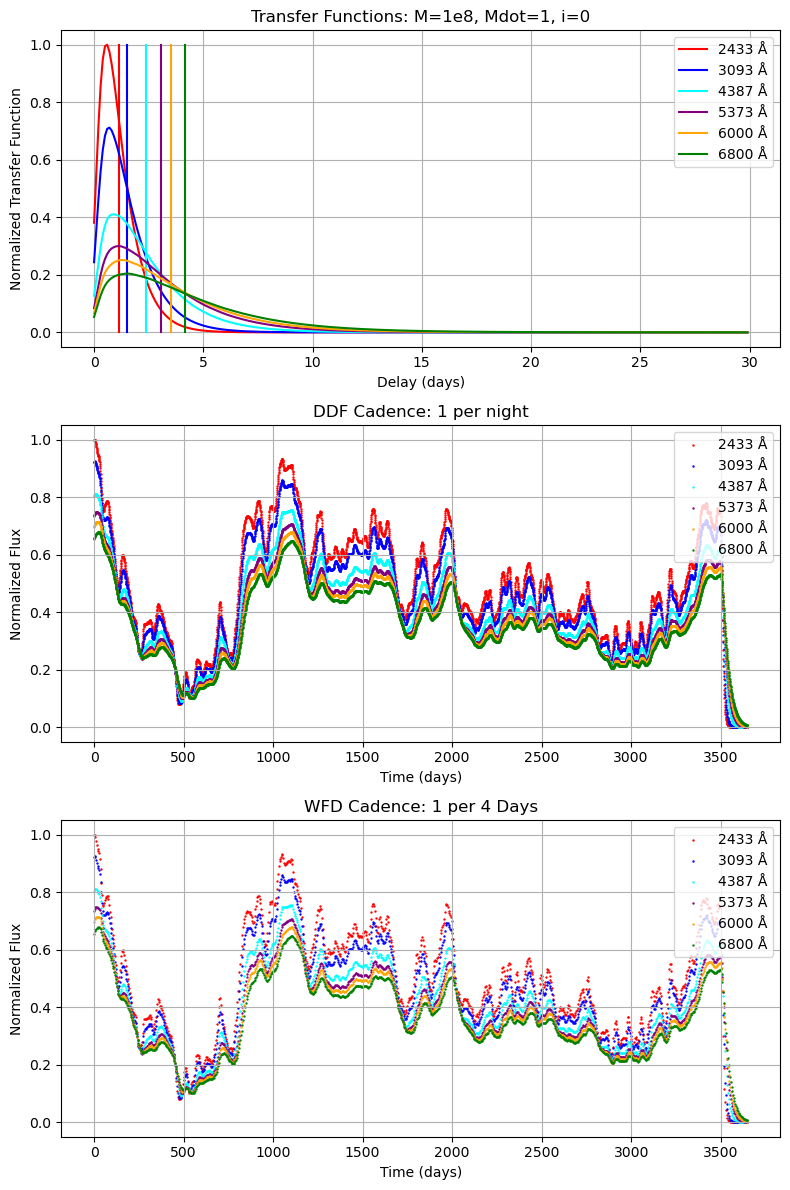

In [12]:
# Define the list of wavelengths
wavref = [3650,4640,6580,8060,9000,10200]
redshift_wav05 = [2433, 3093, 4387, 5373, 6000, 6800]
redshift_wav1 = [1825, 2320, 3290, 4030, 4500, 5100]
redshift_wav2 = [1216, 1546, 2193, 2686, 3000, 3400]
mean_delay = []
color=['r','b','cyan','purple','orange','green','skyplue','magenta']
cadence = 10
normalised_lc = (light_curve - min(light_curve))/(max(light_curve)-min(light_curve))
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
wav_list = redshift_wav05
for i, wav in enumerate(wav_list):
    filename = 'Data/Fiducial/z05/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == wav_list[0]:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    mean_delay.append(mean)
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    errors = abs(np.random.normal(0, 0.05, size=len(normalize_convolved_light_curve)))
    # Normalize the convolved light curve
    #convolved_light_curve = convolved_light_curve #/ max(convolved_light_curve)
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    
    # Plot the convolved light curve
    #axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]-i*0.16,s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[2].scatter(days[::40], normalize_convolved_light_curve[::40]-i*0.1,s=0.5,color=color[i], label=f'{int(wav)} Å')
    axs[1].scatter(days[::1], normalize_convolved_light_curve[::1],s=0.5,color=color[i], label=f'{int(wav)} Å')
    axs[2].scatter(days[::4], normalize_convolved_light_curve[::4],s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]+background_L[i],s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[2].scatter(days[::4], normalize_convolved_light_curve[::4]+background_L[i],s=0.5,color=color[i], label=f'{int(wav)} Å')

    with open( 'Data/Fiducial/z05/' +str(wav)+'_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'normalised_flux [arbitary unit]','error'])  # Write the header
        for tau, flux, error  in zip(days, normalize_convolved_light_curve, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux')
axs[1].set_title('DDF Cadence: 1 per night')
axs[1].legend()
axs[1].grid()

axs[2].set_xlabel('Time (days)')
axs[2].set_ylabel('Normalized Flux')
axs[2].set_title('WFD Cadence: 1 per 4 Days')
axs[2].legend()
axs[2].grid()


plt.tight_layout()

plt.show()

### Scaled Light Curve with Background

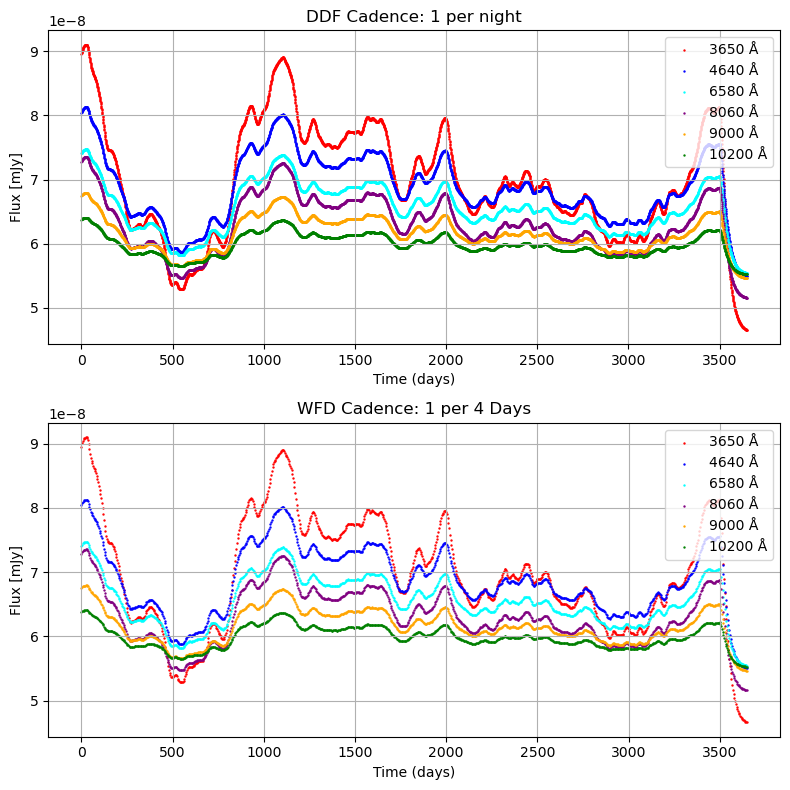

In [13]:
scaled_light_curves = []
#UGRIZY
wavref = [[3650,0.13],[4640,0.078],[6580,0.06],[8060,0.071],[9000,0.044],[10200,0.03]]
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
wav_list = wavref

for i, wav in enumerate(wav_list):
    # Calculate the mean and standard deviation of the convolved light curve
    mean_flux = np.mean(normalize_convolved_light_curve)
    std_flux = np.std(normalize_convolved_light_curve)
    sfinf = mac10_sf(M/M_sol,abs_mag,wav[0])
    #print(sfinf, mean_flux*F_nu2mJy,flux_to_magnitude(mean_flux*F_nu2mJy) )
    #print(fvf_cal(sfinf,flux_to_magnitude(mean_flux*F_nu2mJy)))
    # Scale the light curve
    scaled_lc = (normalize_convolved_light_curve - mean_flux) / std_flux
    scaled_lc = scaled_lc * (wav[1] * background_L[i]) + background_L[i]
    
    scaled_light_curves.append(scaled_lc)

    # Plot the scaled light curve
    axs[0].scatter(days[::1], F_nu2mJy*scaled_lc[::1], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[1].scatter(days[::4], F_nu2mJy*scaled_lc[::4], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    # Save the scaled light curve to a CSV file
    with open('Data/Fiducial/z05/' + str(wav) + '_scaled_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux [mJy]', 'error'])  # Write the header
        for tau, flux, error in zip(days, scaled_lc, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Flux [mJy]')
axs[0].set_title('DDF Cadence: 1 per night')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Flux [mJy]')
axs[1].set_title('WFD Cadence: 1 per 4 Days')
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

316227766.01683795 -25.21122913564288
5.358564391089172 26.801057682829743
fvf:  0.06107413090315077
316227766.01683795 -25.21122913564288
4.776663229388835 26.81084700308389
fvf:  0.05764169981740957
316227766.01683795 -25.21122913564288
4.040699303766953 26.861705898275147
fvf:  0.05291510701214641
316227766.01683795 -25.21122913564288
3.6665047403406326 26.90413258446652
fvf:  0.0503259675279387
316227766.01683795 -25.21122913564288
3.4777997652217976 26.92779759647554
fvf:  0.04897071610664863
316227766.01683795 -25.21122913564288
3.2754219385374355 26.95781083973037
fvf:  0.04747161506083704


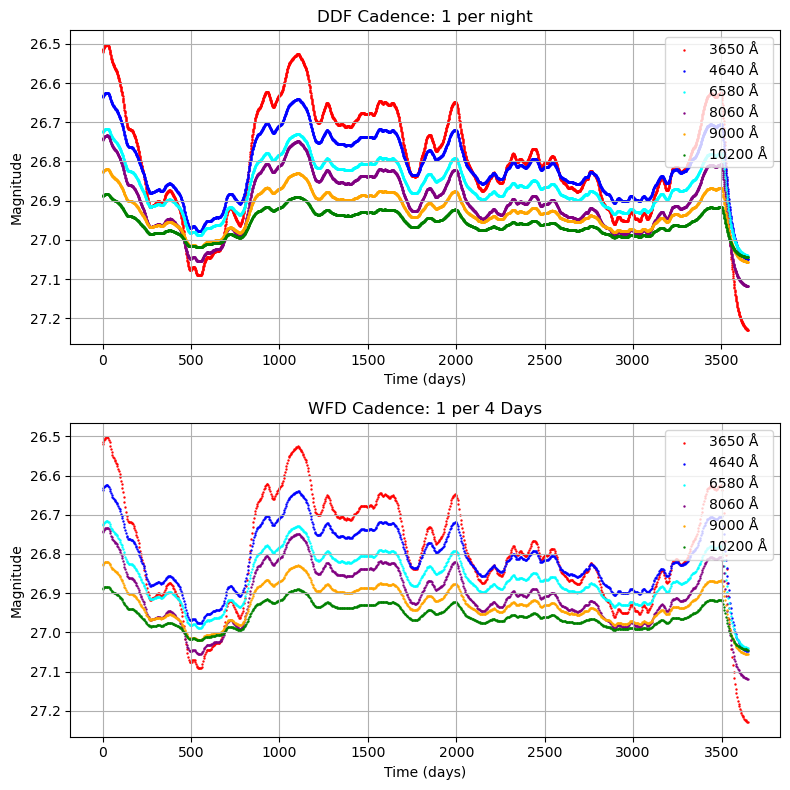

In [18]:
scaled_light_curves = []
#UGRIZY
wavref = [[3650,0.13],[4640,0.078],[6580,0.06],[8060,0.071],[9000,0.044],[10200,0.03]]
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
wav_list = wavref
fvf = []
for i, wav in enumerate(wav_list):
    # Calculate the mean and standard deviation of the convolved light curve
    mean_flux = np.mean(normalize_convolved_light_curve)
    std_flux = np.std(normalize_convolved_light_curve)
    sfinf = mac10_sf(M/M_sol,-13,wav[0])
    print(M/M_sol,abs_mag)
    #print(sfinf, mean_flux*F_nu2mJy,flux_to_magnitude(mean_flux*F_nu2mJy) )
    #print(fvf_cal(sfinf,flux_to_magnitude(mean_flux*F_nu2mJy)))
    # Scale the light curve
    scaled_lc = (normalize_convolved_light_curve - mean_flux) / std_flux
    scaled_lc = scaled_lc * (wav[1] * background_L[i]) + background_L[i]
    
    scaled_light_curves.append(scaled_lc)

    # Plot the scaled light curve
    #axs[0].scatter(days[::1], F_nu2mJy*scaled_lc[::1], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    #axs[1].scatter(days[::4], F_nu2mJy*scaled_lc[::4], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[0].scatter(days[::1], flux_to_magnitude(F_nu2mJy*scaled_lc[::1]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[1].scatter(days[::4], flux_to_magnitude(F_nu2mJy*scaled_lc[::4]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    print(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc)))
    print('fvf: ',fvf_cal(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc))))
    fvf.append(fvf_cal(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc))))
    # Save the scaled light curve to a CSV file
    with open('Data/Fiducial/z05/' + str(wav) + '_scaled_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux [mJy]', 'error'])  # Write the header
        for tau, flux, error in zip(days, scaled_lc, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Magnitude')
axs[0].set_title('DDF Cadence: 1 per night')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('WFD Cadence: 1 per 4 Days')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

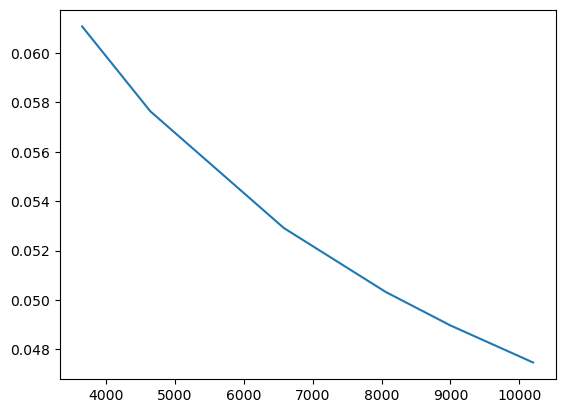

In [20]:
plt.plot([3650,4640,6580,8060,9000,10200],fvf)

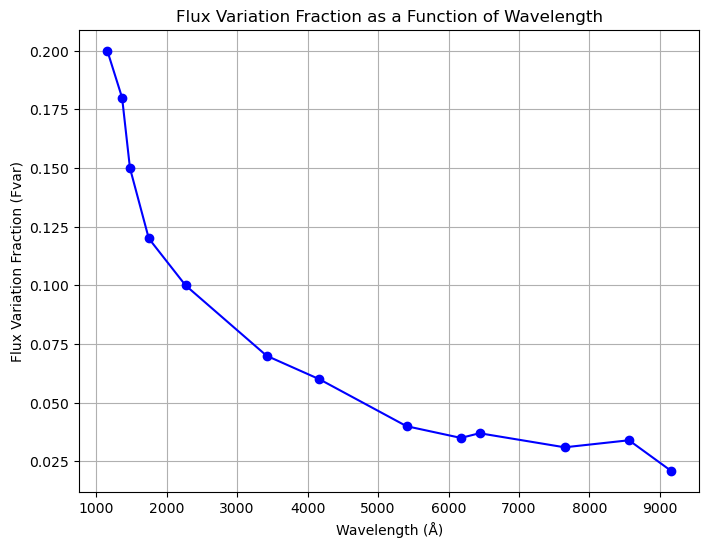

In [16]:
# Extracted data from Table 5 (approximate values)
wavelengths = [1157.5, 1367.0, 1478.5, 1746.0, 2268.0, 3419.0, 4168.0, 5404.0, 6176.0, 6440.0, 7648.0, 8561.0, 9157.0]
flux_variation_fraction = [0.20, 0.18, 0.15, 0.12, 0.10, 0.07, 0.06, 0.04, 0.035, 0.037, 0.031, 0.034, 0.021]  # Estimated from Table 5

# Create DataFrame for visualization
df = pd.DataFrame({"Wavelength (Å)": wavelengths, "Flux Variation Fraction": flux_variation_fraction})

# Plot the flux variation fraction as a function of wavelength
plt.figure(figsize=(8, 6))
plt.plot(df["Wavelength (Å)"], df["Flux Variation Fraction"], marker='o', linestyle='-', color='b')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Variation Fraction (Fvar)")
plt.title("Flux Variation Fraction as a Function of Wavelength")
plt.grid(True)
plt.show()

### Agn Reddening